In [8]:
from sklearn.metrics import mean_squared_error as MSE
from datetime import datetime, timedelta
import random
import shutil
from tqdm import tqdm
import sys
from math import floor
from sklearn.preprocessing import MinMaxScaler
import talib as ta
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from os import walk
import os
from scipy import stats
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.simplefilter(action="ignore", category=RuntimeWarning)



In [53]:
def getDates():
    start = datetime(2019, 1, 1)
    startDate = datetime(1981, 1, 1)

    while startDate < start:
        year = random.randint(0, 22)
        leapyear = False

        if (year % 400 == 0) and (year % 100 == 0) or ((year % 4 == 0) and (year % 100 != 0)):
            leapyear = True

        if year < 10:
                year = year = "200{}".format(year)

        else:
            year = "20{}".format(year)

        month = str(random.randint(1, 12))
        possibleDays = {'1': 31, '2': 28, '3': 31, '4': 30, '5': 31,
                        '6': 30, '7': 31, '8': 31, '9': 30, '10': 31, '11': 30, '12': 31}
        day = str(random.randint(1, possibleDays[month]))

        if leapyear and month is '2':
            day = str(random.randint(1, 29))

        startDate = '{}-{}-{}'.format(year, month, day)

        startDate = datetime.strptime(startDate, "%Y-%m-%d")

    days = timedelta(76)
    endDate = startDate + days
    startDate = str(startDate)[:10]
    endDate = str(endDate)[:10]
    return startDate, endDate


In [54]:
getDates()

('2020-03-21', '2020-06-05')

In [56]:
def company(stock, startDate, endDate, s=1):
    startDate = datetime.strptime(str(startDate), "%Y-%m-%d")
    endDate = datetime.strptime(str(endDate), "%Y-%m-%d")
    model = "Best/Models/{}-model.json".format(stock)
    start = startDate
    dataPath = "/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/Datasets/30y_stock_csvs"
    dataTrain = pd.read_csv("{}/{}.csv".format(dataPath, stock))  # import csv
    dataTrain['Datetime'] = pd.to_datetime(dataTrain['Datetime'])
    if startDate < dataTrain.iloc[0, :]['Datetime']:
        return -1
    days = timedelta(93)
    startDate = startDate - days
    if startDate < dataTrain.iloc[0, :]['Datetime']:
        startDate = dataTrain.iloc[0, :]['Datetime']

    dataTrain = dataTrain[~(dataTrain['Datetime'] < startDate)]
    dataTrain = dataTrain[~(dataTrain['Datetime'] > endDate)]
    rsiPeriod = 14
    adxPeriod = 14
    leftshift = 33
    window = 60

    # %%
    variablesToInclude = ['Close', 'Volume',
                          "RSI", "ADX", "fastd", "fastk", "macd"]
    numberOfFeatures = len(variablesToInclude)

    trainingDataPoints = round(len(dataTrain) * .4)

    dataTrain.rename(columns={'CLOSE': 'Close'}, inplace=True)
    dataTrain.rename(columns={'HIGH': 'High'}, inplace=True)
    dataTrain.rename(columns={'LOW': 'Low'}, inplace=True)
    dataTrain.rename(columns={'VOLUME': 'Volume'}, inplace=True)

    # %%

    dataTrain['Close'] = dataTrain['Close'].astype(float).fillna(0)
    data = dataTrain['Close']
    if len(dataTrain) == 0:
        return 0
    dataTrain["RSI"] = ta.RSI(dataTrain['Close'], rsiPeriod).fillna(0)
    dataTrain["ADX"] = ta.ADX(
        dataTrain['High'], dataTrain['Low'], dataTrain['Close'], adxPeriod).fillna(0)
    fastk, fastd = ta.STOCHF(
        dataTrain['High'], dataTrain['Low'], dataTrain['Close'])
    dataTrain['fastd'] = fastd
    dataTrain['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTrain['Close'])
    dataTrain['macd'] = macd
    dataTrain['macdsignal'] = macdsignal
    dataTrain['macdhist'] = macdhist
    upper, middle, lower = ta.BBANDS(dataTrain['Close'])
    dataTrain['bb_lowerband'] = lower
    dataTrain['bb_middleband'] = middle
    dataTrain['bb_upperband'] = upper

    # %%
    newTrain = pd.DataFrame()
    newTrain = dataTrain[variablesToInclude]
    newTrain["Close"] = newTrain['Close'].shift(1)

    # %%

    # convert to numpy to train RNN
    trainingSet = newTrain.iloc[:, 0:numberOfFeatures].values
    ySet = data.astype(float).values.reshape(-1, 1)

    # %% [markdown]
    # ## Feature Scaling

    # %%
    # Use normalization x - min(x) / max(min) - min(x)
    sc = MinMaxScaler(feature_range=(0, 1))  # all values between 0 and 1
    ySC = MinMaxScaler(feature_range=(0, 1))
    ySCSet = ySC.fit_transform(ySet)
    scaleTrainingSet = sc.fit_transform(trainingSet)

    regressor = tf.keras.models.load_model(model)
    dataTest = dataTrain

    # %%
    newTest = pd.DataFrame()
    newTest = dataTest[variablesToInclude]

    # %%
    realStockPrice = dataTest['Close'].values  # convert to numpy to train RNN
    newTest["Close"] = newTest['Close'].shift(1)
    # convert to numpy to train RNN
    trainingSet = newTest.iloc[:, 0:numberOfFeatures].values

    inputs = trainingSet
    inputs = sc.transform(inputs)

    # %%
    xTest = []
    for i in range(window+leftshift, len(inputs)):
        xTest.append(inputs[i-window:i])
    xTest = np.array(xTest)
    # batchsize, inputSize, numberOfFeatures
    try:
        xTest = np.reshape(
            xTest, (xTest.shape[0], xTest.shape[1], numberOfFeatures))
    except:
        return 0
    # %%
    predictedPrice = regressor.predict(xTest)
    predictedPrice = ySC.inverse_transform(predictedPrice)
    diffrence = (len(realStockPrice)) - (len(predictedPrice))
    realStockPrice = realStockPrice[diffrence-3:]
    stocksOwned = {}
    liquidValue = 500000
    startingValue = liquidValue
    sold =0
    for i in range(len(predictedPrice)):
        if realStockPrice[i] < predictedPrice[i] and 'GOOGL' not in stocksOwned:
            stocksOwned['GOOGL'] = (
                realStockPrice[i], liquidValue/realStockPrice[i])
            liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
            
        elif 'GOOGL' in stocksOwned and stocksOwned['GOOGL'][0] < realStockPrice[i]:
            liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
            percentGain = (
                realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
            sold += 1
            returnDaily = percentGain
            stocksOwned.pop('GOOGL')
        if 'GOOGL' in stocksOwned and i == len(predictedPrice) - 1:
            liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
            percentGain = (
                realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
            stocksOwned.pop('GOOGL')
            sold += 1
    profit = liquidValue - startingValue
    profitPercent = profit / startingValue
    return profitPercent

In [57]:
companies = []
data_path = "Best/Graphs"
for (dirpath, dirnames, filenames) in walk(data_path):
    companies.extend(filenames)
    break

In [58]:
weights = {}

In [63]:
for idx, i in enumerate(companies):
    count = 0
    profitAvg = 0
    i = i[:-4]
    while count < 5:
        profit = -1
        while profit == -1:
            startDate, endDate = getDates()
            profit = company(i,startDate,endDate)
        profitAvg += profit
        count += 1
    profitAvg = profitAvg/count
    weights[i] = profitAvg
    print(f'Number: {idx+1} Company: {i} Profit: {round(profitAvg * 100,2)}%')

Number: 1 Company: APA Profit: -1.15%
Number: 2 Company: TFC Profit: 1.56%
Number: 3 Company: INFO Profit: 0.09%
Number: 4 Company: DAL Profit: 7.3%
Number: 5 Company: CSX Profit: 0.8%
Number: 6 Company: NI Profit: 0.7%
Number: 7 Company: K Profit: -0.95%
Number: 8 Company: AFL Profit: 1.72%
Number: 9 Company: ZION Profit: 3.9%
Number: 10 Company: PFG Profit: 0.32%
Number: 11 Company: NCLH Profit: 2.12%
Number: 12 Company: RJF Profit: 1.3%
Number: 13 Company: UNH Profit: 1.64%
Number: 14 Company: HBAN Profit: 1.51%
Number: 15 Company: PRU Profit: 1.98%
Number: 16 Company: CARR Profit: 2.29%
Number: 17 Company: QCOM Profit: -0.15%
Number: 18 Company: TRMB Profit: 3.81%
Number: 19 Company: BLL Profit: 0.0%
Number: 20 Company: LUV Profit: 1.37%
Number: 21 Company: GIS Profit: 0.0%
Number: 22 Company: LYB Profit: 1.44%
Number: 23 Company: PHM Profit: 1.71%
Number: 24 Company: ROST Profit: 5.65%
Number: 25 Company: OKE Profit: 3.36%
Number: 26 Company: BK Profit: 1.05%
Number: 27 Company: S

In [64]:
weights

{'APA': -0.011543750183952529,
 'TFC': 0.015569221287237317,
 'INFO': 0.0009409320809728932,
 'DAL': 0.07302033721431596,
 'CSX': 0.007973453395666671,
 'NI': 0.006983118427893892,
 'K': -0.009538342222351698,
 'AFL': 0.01723487936435051,
 'ZION': 0.038968510113696966,
 'PFG': 0.00321201410683475,
 'NCLH': 0.02123505968038803,
 'RJF': 0.013006488180123666,
 'UNH': 0.016427722683799453,
 'HBAN': 0.015051504158464213,
 'PRU': 0.01975142347430971,
 'CARR': 0.022887143876606925,
 'QCOM': -0.0015222131590475114,
 'TRMB': 0.03805015323084936,
 'BLL': 0.0,
 'LUV': 0.013667729124708683,
 'GIS': 0.0,
 'LYB': 0.014426051682306129,
 'PHM': 0.017112949311275594,
 'ROST': 0.05647916158128576,
 'OKE': 0.03356293949910235,
 'BK': 0.010487339337113313,
 'SYF': 0.11014979817232495,
 'J': 0.0,
 'LW': 0.012035196269309382,
 'MS': 0.11525623887826679,
 'CPB': 0.018693370609610318,
 'HWM': 0.010626816000684445,
 'MHK': 0.0014492771795611595,
 'CHD': -7.933214358519762e-05,
 'JKHY': 0.012047973495096526,
 '

In [65]:
weights = pd.DataFrame(list(weights.items()), columns=["Company", "Profit"])
weights

,Company,Profit
0,APA,-0.011544
1,TFC,0.015569
2,INFO,0.000941
3,DAL,0.073020
4,CSX,0.007973
...,...,...
498,F,0.027140
499,ADI,0.036061
500,STZ,-0.009638
501,HAL,0.068007


In [66]:
weights.describe()

,Profit
count,503.000000
mean,0.018093
std,0.029997
min,-0.110466
25%,0.000553
50%,0.010648
75%,0.025385
max,0.203579


In [67]:
def normalize(value, sum, length):

    return (value / sum)


def negativeMSE(value, max):
    return (-1 * value)


In [68]:
maxProfit = weights['Profit'].max()
maxProfit


0.20357886044265533

In [69]:
weights['Transformed MSE'] = MinMaxScaler().fit_transform(
    weights['Profit'].values.reshape(-1, 1))

In [70]:
weights.describe()

,Profit,Transformed MSE
count,503.000000,503.000000
mean,0.018093,0.409364
std,0.029997,0.095517
min,-0.110466,0.000000
25%,0.000553,0.353512
50%,0.010648,0.385658
75%,0.025385,0.432584
max,0.203579,1.000000


In [71]:
sums = weights['Transformed MSE'].sum()
print(sums)

205.91016555787246


In [72]:
weights['Weight'] = weights.apply(lambda row: normalize(
    row['Transformed MSE'], sums, len(weights)), axis=1)
weights.to_csv("output.csv", index=False)
weights['Weight'].sum()


1.0

In [73]:
newWeights = weights
newWeights = newWeights[newWeights['Profit'] > 0.05]
length = len(newWeights)
maxMSE = newWeights['Profit'].max()

newWeights['Transformed MSE'] = MinMaxScaler().fit_transform(
    newWeights['Profit'].values.reshape(-1, 1))
sums = newWeights['Transformed MSE'].sum()

newWeights['Weight'] = newWeights.apply(lambda row: normalize(
    row['Transformed MSE'], sums, length), axis=1)
newWeights['Weight'].sum()


0.9999999999999999

In [48]:
newWeights.describe()

,Profit,Transformed MSE,Weight
count,83.000000,83.000000,83.000000
mean,0.071607,0.156834,0.012048
std,0.024943,0.182742,0.014039
min,0.050201,0.000000,0.000000
25%,0.054492,0.031439,0.002415
50%,0.060962,0.078846,0.006057
75%,0.083342,0.242805,0.018653
max,0.186693,1.000000,0.076821


<AxesSubplot:xlabel='index', ylabel='Profit'>

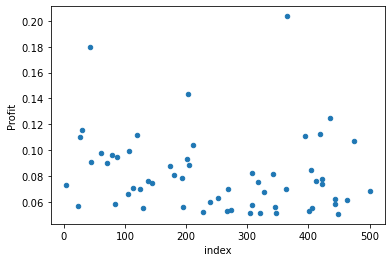

In [74]:
newWeights.reset_index().plot.scatter(x='index', y='Profit')

<AxesSubplot:ylabel='Density'>

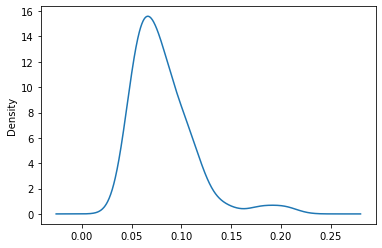

In [75]:
newWeights['Profit'].plot.density()

In [76]:
newWeights[newWeights['Weight'] == newWeights['Weight'].max()]

,Company,Profit,Transformed MSE,Weight
365,NXPI,0.203579,1.0,0.084705


In [52]:
newWeights.to_csv("outputWeights.csv", index=False)